In [33]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import mnist

# Определяем классы

class Layer:
    """
    Базовый класс для слоев нейронной сети.

    Методы:
    forward(x): Вычисляет прямое распространение.
    backward(grad_output): Вычисляет обратное распространение.
    """

    def forward(self, x):
        """
        Выполняет прямое распространение через слой.

        Параметры:
            x: Входные данные для слоя.

        Возвращает:
            Результат прямого распространения.
        """
        raise NotImplementedError("Forward method not implemented.")

    def backward(self, grad_output):
        """
        Выполняет обратное распространение через слой.

        Параметры:
            grad_output: Градиенты на выходе слоя.

        Возвращает:
            Градиенты на входе слоя.
        """
        raise NotImplementedError("Backward method not implemented.")

class Model:
    """
    Класс модели нейронной сети.

    Методы:
    add(layer): Добавляет слой в модель.
    forward(x): Выполняет прямое распространение через модель.
    backward(grad_output): Выполняет обратное распространение через модель.
    compile(optimizer, loss_function): Компилирует модель с оптимизатором и функцией потерь.
    create_minibatches(data, labels, batch_size): Генерирует мини-батчи из данных и меток.
    fit(x_train, y_train, epochs, batch_size): Обучает модель на обучающих данных.
    """

    def __init__(self):
        self.layers = []

    def add(self, layer):
        """
        Добавляет слой в модель.

        Параметры:
            layer: Слой для добавления в модель.
        """
        self.layers.append(layer)

    def forward(self, x):
        """
        Выполняет прямое распространение через модель.

        Параметры:
            x: Входные данные для модели.

        Возвращает:
            Выходные данные модели.
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        """
        Выполняет обратное распространение через модель.

        Параметры:
            grad_output: Градиенты на выходе модели.
        """
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def compile(self, optimizer, loss_function):
        """
        Компилирует модель с заданным оптимизатором и функцией потерь.

        Параметры:
            optimizer: Оптимизатор для обновления параметров модели.
            loss_function: Функция потерь для вычисления градиентов.
        """
        self.optimizer = optimizer
        self.loss_function = loss_function

    def create_minibatches(self, data, labels, batch_size):
        """
        Генерирует мини-батчи из данных и меток.

        Параметры:
            data: Входные данные.
            labels: Метки данных.
            batch_size: Размер мини-батча.

        Возвращает:
            Генератор мини-батчей.
        """
        num_samples = data.shape[0]
        for i in range(0, num_samples, batch_size):
            yield data[i:i + batch_size], labels[i:i + batch_size]

    def fit(self, x_train, y_train, epochs, batch_size):
        """
        Обучает модель на обучающих данных.

        Параметры:
            x_train: Обучающие данные.
            y_train: Обучающие метки.
            epochs: Количество эпох обучения.
            batch_size: Размер батча для обучения.
        """
        num_samples = x_train.shape[0]

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]

            for x_batch, y_batch in self.create_minibatches(x_train, y_train, batch_size):
                # Прямое распространение
                y_pred = self.forward(x_batch)

                # Вычисляем потерю и градиенты
                loss = self.loss_function.forward(y_batch, y_pred)
                grad_loss = self.loss_function.backward(y_batch, y_pred)
                self.backward(grad_loss)

                # Обновляем параметры с использованием градиентного обрезания
                self.optimizer.step(self)

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')

class Optimizer:
    """
    Базовый класс для оптимизаторов нейронной сети.

    Методы:
    step(model): Обновляет параметры модели.
    """
    def step(self, model):
        """
        Обновляет параметры модели.

        Параметры:
            model: Модель для обновления параметров.
        """
        raise NotImplementedError("Step method not implemented.")

class LossFunction:
    """
    Базовый класс для функций потерь.

    Методы:
    forward(y_true, y_pred): Вычисляет значение функции потерь.
    backward(y_true, y_pred): Вычисляет градиенты функции потерь.
    """
    def forward(self, y_true, y_pred):
        """
        Вычисляет значение функции потерь.

        Параметры:
            y_true: Истинные метки.
            y_pred: Предсказанные метки.

        Возвращает:
            Значение функции потерь.
        """
        raise NotImplementedError("Forward method not implemented.")

    def backward(self, y_true, y_pred):
        """
        Вычисляет градиенты функции потерь.

        Параметры:
            y_true: Истинные метки.
            y_pred: Предсказанные метки.

        Возвращает:
            Градиенты функции потерь относительно предсказаний.
        """
        raise NotImplementedError("Backward method not implemented.")

class Dense(Layer):
    """
    Полносвязный слой нейронной сети.

    Атрибуты:
    weights: Веса слоя.
    bias: Смещения слоя.
    activation: Функция активации слоя.

    Методы:
    forward(x): Выполняет прямое распространение через слой.
    backward(grad_output): Выполняет обратное распространение через слой.
    """
    def __init__(self, input_dim, output_dim, activation=None):
        """
        Инициализирует полносвязный слой.

        Параметры:
            input_dim: Размер входного вектора.
            output_dim: Размер выходного вектора.
            activation: Функция активации (по умолчанию None).
        """
        super().__init__()
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
        self.activation = activation

    def forward(self, x):
        """
        Выполняет прямое распространение через полносвязный слой.

        Параметры:
            x: Входные данные для слоя.

        Возвращает:
            Выходные данные слоя после применения активации (если задана).
        """
        self.input = x
        z = np.dot(x, self.weights) + self.bias
        if self.activation:
            return self.activation.forward(z)
        return z

    def backward(self, grad_output):
        """
        Выполняет обратное распространение через полносвязный слой.

        Параметры:
            grad_output: Градиенты на выходе слоя.

        Возвращает:
            Градиенты на входе слоя.
        """
        if self.activation:
            grad_output = self.activation.backward(grad_output)
        grad_input = np.dot(grad_output, self.weights.T)
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        return grad_input

class Sigmoid:
    """
    Класс активации Sigmoid.

    Методы:
    forward(x): Вычисляет прямое распространение активации Sigmoid.
    backward(grad_output): Вычисляет градиент функции потерь относительно входа.
    """

    def forward(self, x):
        """
        Вычисляет активацию Sigmoid.
        Параметры:
            x: Входные данные.
        Возвращает:
            Вывод активации Sigmoid.
        """
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, grad_output):
        """
        Вычисляет градиент функции потерь относительно входа для Sigmoid.
        Параметры:
            grad_output: Градиент потерь относительно выхода активации.
        Возвращает:
            Градиент потерь относительно входа активации.
        """
        grad_input = grad_output * (self.output * (1 - self.output))
        return grad_input

class ReLU:
    """
    Класс активации ReLU (Rectified Linear Unit).

    Методы:
    forward(x): Вычисляет прямое распространение активации ReLU.
    backward(grad_output): Вычисляет градиент функции потерь относительно входа.
    """
    def forward(self, x):
        """
        Вычисляет активацию ReLU.

        Параметры:
            x: Входные данные.

        Возвращает:
            Выход активации ReLU, где все отрицательные значения заменены на 0.
        """
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        """
        Вычисляет градиенты функции потерь относительно входа.

        Параметры:
            grad_output: Градиенты на выходе.

        Возвращает:
            Градиенты на входе, зависящие от активации ReLU.
        """
        return grad_output * (self.input > 0)

class Softmax:
    """
    Класс активации Softmax.

    Методы:
    forward(x): Вычисляет прямое распространение активации Softmax.
    backward(grad_output): Вычисляет градиент функции потерь относительно входа.
    """
    def forward(self, x):
        """
        Вычисляет активацию Softmax.

        Параметры:
            x: Входные данные.

        Возвращает:
            Вероятности классов после применения Softmax.
        """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def backward(self, grad_output):
        """
        Вычисляет градиенты функции потерь относительно входа.

        Параметры:
            grad_output: Градиенты на выходе.

        Возвращает:
            Градиенты на входе. Предполагается использование с кросс-энтропией.
        """
        return grad_output  # Здесь предполагается использование с кросс-энтропией

class MSE(LossFunction):
    """
    Класс функции потерь MSE (Mean Squared Error).

    Методы:
    forward(y_true, y_pred): Вычисляет значение функции потерь.
    backward(y_true, y_pred): Вычисляет градиенты функции потерь.
    """
    def forward(self, y_true, y_pred):
        """
        Вычисляет значение функции потерь MSE.

        Параметры:
            y_true: Истинные метки.
            y_pred: Предсказанные метки.

        Возвращает:
            Значение функции потерь MSE.
        """
        return np.mean((y_true - y_pred) ** 2)

    def backward(self, y_true, y_pred):
        """
        Вычисляет градиенты функции потерь MSE.

        Параметры:
            y_true: Истинные метки.
            y_pred: Предсказанные метки.

        Возвращает:
            Градиенты функции потерь MSE относительно предсказаний.
        """
        return -2 * (y_true - y_pred) / y_true.size

class SGD(Optimizer):
    """
    Класс стохастического градиентного спуска (SGD).

    Атрибуты:
    learning_rate: Скорость обучения.

    Методы:
    step(model): Обновляет параметры модели.
    """
    def __init__(self, learning_rate=0.01):
        """
        Инициализирует SGD с заданной скоростью обучения.

        Параметры:
            learning_rate: Скорость обучения (по умолчанию 0.01).
        """
        self.learning_rate = learning_rate

    def step(self, model):
        """
        Обновляет параметры модели.

        Параметры:
            model: Модель для обновления параметров.
        """
        for layer in model.layers:
            if hasattr(layer, 'weights'):
                layer.weights -= self.learning_rate * layer.grad_weights
                layer.bias -= self.learning_rate * layer.grad_bias

class MomentumSGD(Optimizer):
    """
    Класс стохастического градиентного спуска с моментумом.

    Атрибуты:
    learning_rate: Скорость обучения.
    momentum: Коэффициент моментума.
    v_weights: Веса моментума.
    v_bias: Смещения моментума.

    Методы:
    step(model): Обновляет параметры модели с учетом моментума.
    """
    def __init__(self, learning_rate=0.01, momentum=0.9):
        """
         Инициализирует MomentumSGD с заданной скоростью обучения и моментумом.

        Параметры:
            learning_rate: Скорость обучения (по умолчанию 0.01).
            momentum: Коэффициент моментума (по умолчанию 0.9).
        """
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v_weights = None
        self.v_bias = None

    def step(self, model):
        """
        Обновляет параметры модели с учетом моментума.

        Параметры:
            model: Модель для обновления параметров.
        """
        if self.v_weights is None:
            # Инициализация моментума
            self.v_weights = [np.zeros_like(layer.weights) for layer in model.layers if hasattr(layer, 'weights')]
            self.v_bias = [np.zeros_like(layer.bias) for layer in model.layers if hasattr(layer, 'bias')]

        for i, layer in enumerate(model.layers):
            if hasattr(layer, 'weights'):
                # Обновление весов с моментумом
                self.v_weights[i] = self.momentum * self.v_weights[i] - self.learning_rate * layer.grad_weights
                layer.weights += self.v_weights[i]

                # Обновление смещения с моментумом
                self.v_bias[i] = self.momentum * self.v_bias[i] - self.learning_rate * layer.grad_bias
                layer.bias += self.v_bias[i]

class GradientClipping:
    """
    Класс для обрезки градиентов.

    Методы:
    clip(gradients, max_norm): Обрезает градиенты до заданной нормы.
    """
    @staticmethod
    def clip(gradients, max_norm):
        """
        Обрезает градиенты до заданной нормы.

        Параметры:
            gradients: Список градиентов для обрезки.
            max_norm: Максимальная норма для обрезки градиентов.

        Возвращает:
            Обрезанные градиенты.
        """
        total_norm = np.sqrt(sum(np.sum(g ** 2) for g in gradients))
        if total_norm > max_norm:
            scale = max_norm / total_norm
            return [g * scale for g in gradients]
        return gradients


class CategoricalCrossentropy(LossFunction):
    """
    Класс функции потерь кросс-энтропии для категориальных данных.

    Методы:
    forward(y_true, y_pred): Вычисляет значение функции потерь.
    backward(y_true, y_pred): Вычисляет градиенты функции потерь.
    """
    def forward(self, y_true, y_pred):
        """
        Вычисляет значение функции потерь кросс-энтропии.

        Параметры:
            y_true: Истинные метки (one-hot encoding).
            y_pred: Предсказанные вероятности классов.

        Возвращает:
            Значение функции потерь кросс-энтропии.
        """
        # Добавляем небольшое значение для предотвращения логарифма нуля
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def backward(self, y_true, y_pred):
        """
        Вычисляет градиенты функции потерь кросс-энтропии.

        Параметры:
            y_true: Истинные метки (one-hot encoding).
            y_pred: Предсказанные вероятности классов.

        Возвращает:
            Градиенты функции потерь кросс-энтропии относительно предсказаний.
        """
        return (y_pred - y_true) / y_true.shape[0]

class BinaryCrossentropy(LossFunction):
    """
    Класс функции потерь бинарной кросс-энтропии.

    Методы:
    forward(y_true, y_pred): Вычисляет значение функции потерь.
    backward(y_true, y_pred): Вычисляет градиенты функции потерь.
    """
    def forward(self, y_true, y_pred):
        """
        Вычисляет значение функции потерь бинарной кросс-энтропии.

        Параметры:
            y_true: Истинные метки (0 или 1).
            y_pred: Предсказанные вероятности (в диапазоне [0, 1]).

        Возвращает:
            Значение функции потерь бинарной кросс-энтропии.
        """
        # Добавляем небольшое значение для предотвращения логарифма нуля
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, y_true, y_pred):
        """
        Вычисляет градиенты функции потерь бинарной кросс-энтропии.

        Параметры:
            y_true: Истинные метки (0 или 1).
            y_pred: Предсказанные вероятности (в диапазоне [0, 1]).

        Возвращает:
            Градиенты функции потерь бинарной кросс-энтропии относительно предсказаний.
        """
        return (y_pred - y_true) / (y_true.shape[0] * (y_pred * (1 - y_pred)))

class HuberLoss(LossFunction):
    """
    Класс функции потерь Huber Loss.

    Атрибуты:
    delta: Порог для разделения малых и больших ошибок.

    Методы:
    forward(y_true, y_pred): Вычисляет значение функции потерь.
    backward(y_true, y_pred): Вычисляет градиенты функции потерь.
    """
    def __init__(self, delta=1.0):
        """
        Инициализирует Huber Loss с заданным порогом.

        Параметры:
            delta: Порог для разделения малых и больших ошибок (по умолчанию 1.0).
        """
        self.delta = delta

    def forward(self, y_true, y_pred):
        """
        Вычисляет значение функции потерь Huber Loss.

        Параметры:
            y_true: Истинные метки.
            y_pred: Предсказанные метки.

        Возвращает:
            Значение функции потерь Huber Loss.
        """
        error = y_true - y_pred
        is_small_error = np.abs(error) <= self.delta
        squared_loss = 0.5 * error ** 2
        linear_loss = self.delta * (np.abs(error) - 0.5 * self.delta)
        return np.mean(np.where(is_small_error, squared_loss, linear_loss))

    def backward(self, y_true, y_pred):
        """
        Вычисляет градиенты функции потерь Huber Loss.

        Параметры:
            y_true: Истинные метки.
            y_pred: Предсказанные метки.

        Возвращает:
            Градиенты функции потерь Huber Loss относительно предсказаний.
        """
        error = y_true - y_pred
        is_small_error = np.abs(error) <= self.delta
        grad = np.where(is_small_error, error, self.delta * np.sign(error))
        return -grad / y_true.size

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/1, Loss: 0.3572
Epoch 1/10, Train Loss: 0.5265, Test Loss: 0.5102
Epoch 1/1, Loss: 0.4937
Epoch 2/10, Train Loss: 0.3712, Test Loss: 0.3554
Epoch 1/1, Loss: 0.4108
Epoch 3/10, Train Loss: 0.3243, Test Loss: 0.3116
Epoch 1/1, Loss: 0.1607
Epoch 4/10, Train Loss: 0.2954, Test Loss: 0.2844
Epoch 1/1, Loss: 0.3382
Epoch 5/10, Train Loss: 0.2739, Test Loss: 0.2653
Epoch 1/1, Loss: 0.1337
Epoch 6/10, Train Loss: 0.2553, Test Loss: 0.2479
Epoch 1/1, Loss: 0.1536
Epoch 7/10, Train Loss: 0.2397, Test Loss: 0.2360
Epoch 1/1, Loss: 0.1375
Epoch 8/10, Train Loss: 0.2272, Test Loss: 0.2267
Epoch 1/1, Loss: 0.2312
Epoch 9/10, Train Loss: 0.2133, Test Loss: 0.2112
Epoch 1/1, Loss: 0.0741
Epoch 10/10, Train Loss: 0.2016, Test Loss: 0.1988


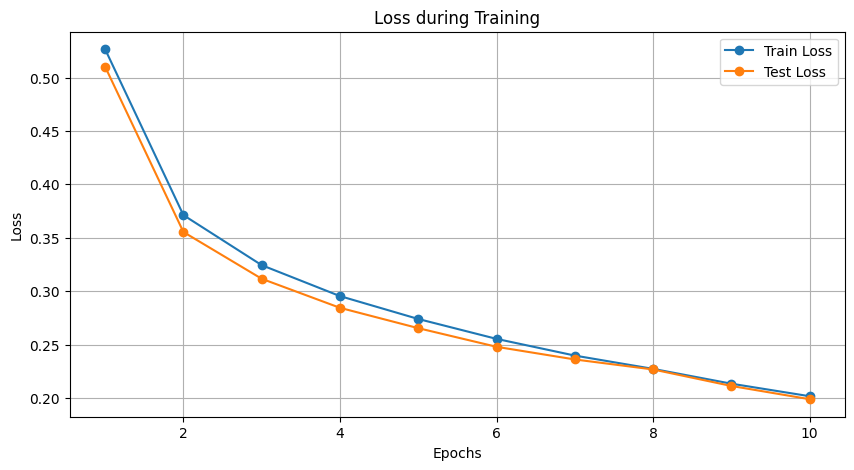

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist

# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Предобработка данных
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

# Преобразование меток в one-hot формат
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Создание модели
model = Model()
model.add(Dense(784, 128, activation=ReLU()))
model.add(Dense(128, 10, activation=Softmax()))

# Компиляция модели
model.compile(optimizer=SGD(learning_rate=0.01), loss_function=CategoricalCrossentropy())

# Списки для хранения потерь
train_losses = []
test_losses = []

# Обучение модели
epochs = 10
batch_size = 32

for epoch in range(epochs):
    # Обучение на обучающих данных
    model.fit(x_train, y_train_onehot, epochs=1, batch_size=batch_size)

    # Оценка на тестовых данных
    y_train_pred = model.forward(x_train)
    train_loss = model.loss_function.forward(y_train_onehot, y_train_pred)
    train_losses.append(train_loss)

    y_test_pred = model.forward(x_test)
    test_loss = model.loss_function.forward(y_test_onehot, y_test_pred)
    test_losses.append(test_loss)

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', marker='o')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/1, Loss: 0.5084
Epoch 1/1, Loss: 0.5335
Epoch 1/1, Loss: 0.2208
Epoch 1/1, Loss: 0.4338
Epoch 1/1, Loss: 0.4256


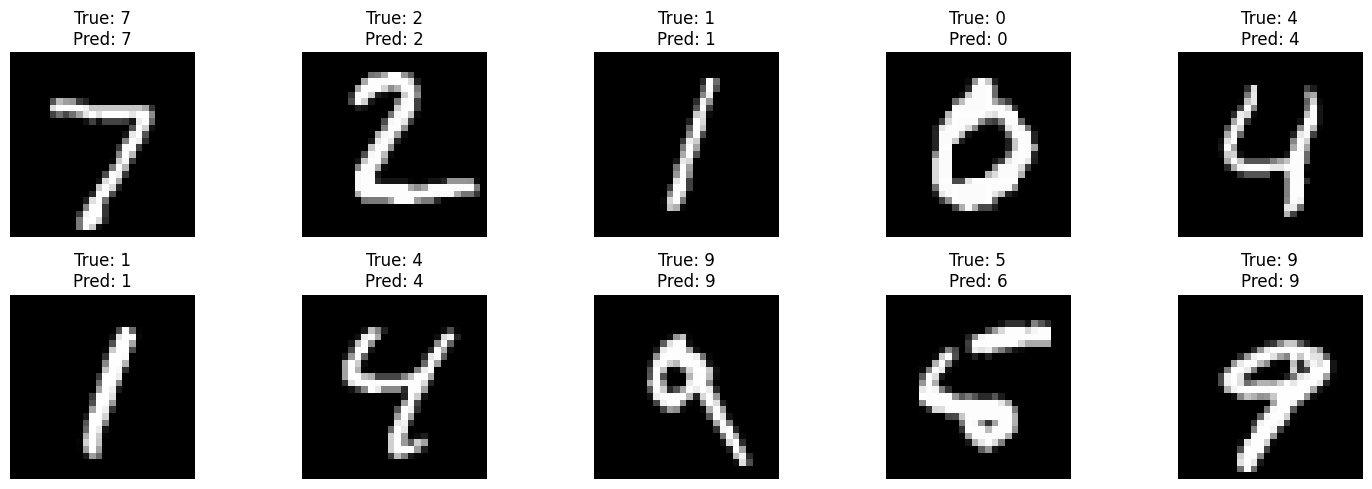

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist

# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Предобработка данных
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

# Преобразование меток в one-hot формат
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Создание модели
model = Model()
model.add(Dense(784, 128, activation=ReLU()))
model.add(Dense(128, 10, activation=Softmax()))

# Компиляция модели
model.compile(optimizer=SGD(learning_rate=0.01), loss_function=CategoricalCrossentropy())

# Обучение модели (как в предыдущем примере)
epochs = 5
batch_size = 32

for epoch in range(epochs):
    model.fit(x_train, y_train_onehot, epochs=1, batch_size=batch_size)

# Предсказание на тестовом наборе данных
y_test_pred = model.forward(x_test)
predicted_classes = np.argmax(y_test_pred, axis=1)

# Визуализация результатов
def plot_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Визуализируем первые 10 предсказаний
plot_predictions(x_test, y_test, predicted_classes)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/1, Loss: 2.2892
Epoch 1/1, Loss: 2.2839
Epoch 1/1, Loss: 1.3694
Epoch 1/1, Loss: 0.6101
Epoch 1/1, Loss: 0.3222
Epoch 1/1, Loss: 0.3595
Epoch 1/1, Loss: 0.3352
Epoch 1/1, Loss: 0.4250
Epoch 1/1, Loss: 0.2641
Epoch 1/1, Loss: 0.7449


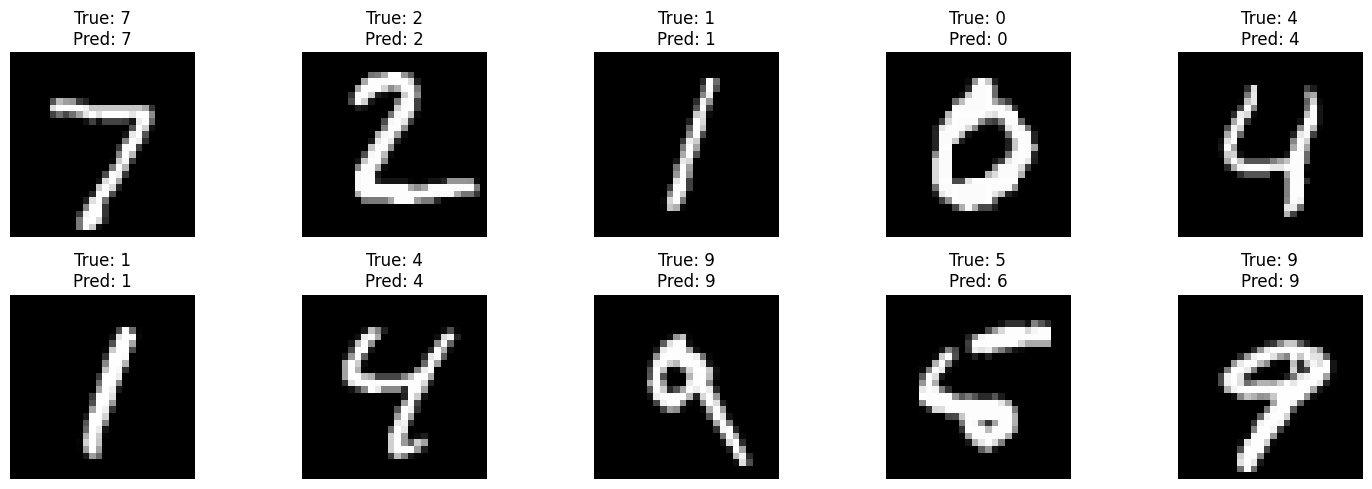

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist

# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Предобработка данных
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

# Преобразование меток в one-hot формат
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Создание модели с регуляризацией
model = Model()
model.add(Dense(784, 256, activation=ReLU()))
model.add(Dense(256, 128, activation=ReLU()))
model.add(Dense(128, 10, activation=Softmax()))

# Компиляция модели с другим оптимизатором
model.compile(optimizer=MomentumSGD(learning_rate=0.001), loss_function=CategoricalCrossentropy())

# Обучение модели
epochs = 10  # Увеличение количества эпох для лучшего обучения
batch_size = 64  # Увеличение размера батча

for epoch in range(epochs):
    model.fit(x_train, y_train_onehot, epochs=1, batch_size=batch_size)

# Предсказание на тестовом наборе данных
y_test_pred = model.forward(x_test)
predicted_classes = np.argmax(y_test_pred, axis=1)

# Визуализация результатов
def plot_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_classes[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Визуализируем первые 10 предсказаний
plot_predictions(x_test, y_test, predicted_classes)
